In [34]:
import numpy as np #Procesamiento numerico
import scipy as sc #Aniade funcionalidad de numpy
import matplotlib.pyplot as plt #Graficos

from sklearn.datasets import make_circles #Funcionalidades para ML

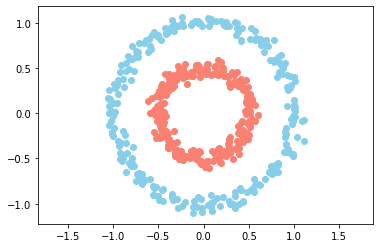

In [36]:
# Crear el dataset

n = 500 #Numero de registros (ej : 500 personas)
p = 2 #Caracteristicas de nuestros datos (ej : edad y altura de personas)

X, Y = make_circles(n_samples= n, factor=0.5, noise=0.05)

Y = Y[:, np.newaxis] #Se añade una nueva dimension para que no devuelva una serie

#Visualizacion de los datos
plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], c = "skyblue")
plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], c = "salmon")
plt.axis("equal")

plt.show()

In [39]:
class neural_layer(): #Clase nueva capa de la red
    def __init__(self, n_conn, n_neur, act_f):
        ''' Parametros : 
                Numero de conexiones
                Numero de neuronas
                Funcion de activacion que se ejecuta en las neuronas de la capa'''

        self.act_f = act_f #Funcion de activacion 
        self.b = np.random.rand(1, n_neur) *2 -1 #BIAS = Numero aleatorio entre -1 y 1 
        self.W = np.random.rand(n_conn, n_neur) *2 -1 #Matriz(Vector W) 


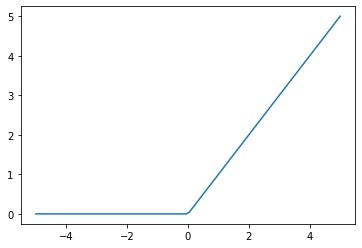

In [41]:
#Funciones de activacion

sigm = (lambda x: 1 / (1 + np.e ** (-x)), #Funcion sigmoide -> 1 partido de 1 + e elevado a -x
        lambda x: x * (1 -x)) #Funcion Derivada de la anterior

relu = lambda x: np.maximum(0, x) #Funcion ReLU : el maximo entre 0 y x

_x = np.linspace(-5, 5, 100) #Vector de 100 valores de -5 a 5 de forma lineal
#plt.plot(_x, sigm(_x)) #Plot  eje X = _X , Y = Resultado de pasar por la funcion sigmoide a _X 
# plt.plot(_x, sigm[1](_x)) #Para ver la derivada
plt.plot(_x, relu(_x)) #Ver funcion RELU

In [42]:
l0 = neural_layer(p, 4, sigm) #Capa 0 con entrada p, 4 neuronas y la funcion sigmoide
l1 = neural_layer(4, 8, sigm)
#...



def create_nn(topology, act_f):
    nn = [] #Vector para contener las capas de la red neuronal
    
    for l, layer in enumerate(topology[: -1]):
        nn.append(neural_layer(topology[l], topology[l+1], act_f)) 

    return nn


In [78]:
''' p = numero de neuronas de la primera capa
    siguiente 4, 8, 16...
    Ultima capa 1, resultado binario 0 o 1 
'''
topology = [p, 4, 8, 1] #Creamos las capas 

neural_net = create_nn(topology, sigm) #Estructura de datos que soporta nuestra red neuronal

''' 
Funcion de coste: 
    Error cuadratico medio :
        Para dos valores de entrada :
            Yp : valor de nuestra nn
            Yr : valor real
        Calculamos la diferencia y elevamos al cuadrado
        Hacemos la media del vector 
'''
l2_cost = (lambda Yp, Yr: np.mean((Yp - Yr) **2),
           lambda Yp, Yr: (Yp - Yr)) #Derivada

def train(neural_net, X, Y, l2_cost, lr=0.5, train=True): #lr = learning rate
    '''Forward pass
        Pasa nuestro vector de entrada y lo pasa capa por capa ejecutando
        las operaciones que se realizan en cada neurona :
            -Suma ponderada : multiplica el valor de entrada X por W + parametro Bias
            -Pasar suma ponderada a una funcion de activacion que hemos definido
    '''

    ''' 
    Suma ponderada que se ejecuta en la primera capa:
        X multiplicado matricialmente por el parametro W(pesos) de lo que tengamos en la primera capa
        Sumado al parametro BIAS 
    '''
    out = [(None, X)] #Vector de resultado con capa vacia para la entrada
    for l, layer in enumerate(neural_net):
        
        z = out[-1][1] @ neural_net[l].W + neural_net[l].b 
        a = neural_net[l].act_f[0](z) #Activacion 

        out.append((z,a))

    #print(out[-1][1])

    if train :
        #Backward pass
            #Calculo de Delta
            deltas = []
            #Bucle for hacia atrás
            for l in reversed(range(0, len(neural_net))):
                
                z = out[l+1][0]
                a = out[l+1][1]

                if l == len(neural_net) - 1:
                    ''' Calcula Delta en ultima capa
                            Derivada de la funcion de coste y 
                            la derivada de la funcion de activacion en la ultima capa
                    '''
                    deltas.insert(0, l2_cost[1](a, Y) * neural_net[l].act_f[1](a))
                else:
                    ''' Calcula Delta respecto a capa previa
                            Delta de la capa anterior en posicion 0 del vector de deltas
                            Multiplicado matricialmente por W(pesos) correspondiente
                            a la capa siguiente a la que nos encontramos ahora (l+1)
                            Que es donde está el error y lo vamos a mover hacia atrás
                            (back propagation)
                    '''
                    deltas.insert(0, deltas[0] @ _W.T * neural_net[l].act_f[1](a)) 
                
                _W = neural_net[l].W
                '''
                Gradient descent
                    Gradient descent necesita actualizar los valores haciendo uso de las deltas                          anteriores.
                    Pasando por cada capa de la red neuronal actualizando los parametros
                    Lo hacemos dentro del for para no tener que recorrer capa por capa de nuevo
                '''
                neural_net[l].b = neural_net[l].b - np.mean(deltas[0], axis=0, keepdims=True) * lr
                neural_net[l].W = neural_net[l].W - out[l][1].T @ deltas[0] * lr
        
    return out[-1][1]

train(neural_net, X, Y, l2_cost, 0.5) #Mostramos resultado, en este caso aun aleatorio
print("")

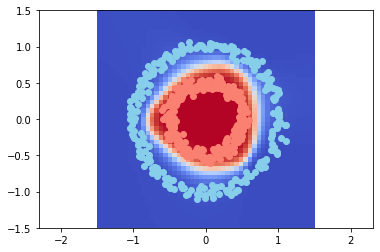

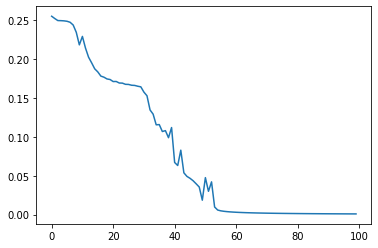

In [84]:
#Visualizacion y test
import time
from IPython.display import clear_output

neural_n = create_nn(topology, sigm) #Creamos una red nueva usando la tipologia y el sigmoide definidos antes

loss = [] #Variable para almacenar los costes y poder verlos

#Iteramos 1000 veces llamando a train
for i in range(2500):

    pY = train(neural_n, X, Y, l2_cost, lr=0.05)

    if i % 25 == 0: #Cada 25 iteraciones
        loss.append(l2_cost[0](pY, Y)) #calculamos el coste y lo añadimos al vector

        res = 50 #Resolucion, malla de 50x50

        _x0 = np.linspace(-1.5, 1.5, res)
        _x1 = np.linspace(-1.5, 1.5, res)

        _Y = np.zeros((res, res))

        for i0, x0 in enumerate(_x0):
            for i1, x1 in enumerate(_x1):
                _Y[i0, i1] = train(neural_n, np.array([[x0, x1]]), Y, l2_cost, train=False)[0][0]
        
        #Visualizaciones
        plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
        plt.axis("equal")

        plt.scatter(X[Y[:,0] == 0, 0], X[Y[:,0] == 0, 1], c="skyblue")
        plt.scatter(X[Y[:,0] == 1, 0], X[Y[:,0] == 1, 1], c="salmon")

        #Borra el contenido y lo vuelve a dibujar para verlo de forma animada
        clear_output(wait=True)
        plt.show()
        plt.plot(range(len(loss)), loss)
        plt.show()
        time.sleep(0.5)